# AVISOS IMPORTANTES

- No futuro, fazer uma análise de tempo de vaga aberta. Para isso, teríamos que criar um outro webscraping para monitorar o fechamento das vagas.


# Imports

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
import seaborn as sns 

import ast

## Funções Auxiliares

In [2]:
def barplot(title:str, 
            group:str, 
            agg:str, 
            agg_name:str, 
            data:pd.DataFrame, 
            agg_func:str, 
            figure= plt.figure, 
            title_font_size:int =10, 
            figsize=(10,5),
            subplot:plt.subplot = None, 
            grid:list = None, 
            label=True,
            rotation_label:int = 45,
            position_label:str = 'center',
            color_label:str = 'white',
            size_label:str = 'small',
            sort: bool = True, 
            hue:str = None,
            stacked:bool = False,
            orient:str = 'h'):
    
    group_list = [group]
    if hue:
        group_list.append(hue)

    # group data
    aux = data[group_list + [agg]].groupby(group_list).agg(agg_func).reset_index().rename(columns={agg:agg_name})

    if sort:
        aux = aux.sort_values(agg_name, ascending=False)
        
    # plot
    if subplot:
        subplot(grid)
    else:
        figure(figsize=figsize)

    # plot configs
    plt.title(title, fontsize=title_font_size)
    plt.xticks(rotation = rotation_label)

    # figure
    if orient == 'h':
        g = sns.barplot(x = group, y = agg_name, hue = hue, dodge = not stacked, data = aux)
    elif orient == 'v':
        g = sns.barplot(y = group, x = agg_name, hue = hue, dodge = not stacked, data = aux)
    else:
        raise('Valor de orient inválido')

    if label:
        for i in g.containers:
            g.bar_label(i, color = color_label, label_type=position_label, fontsize = size_label)
    else:
        pass

def unstacked_plot(
            title:str, 
            group:str, 
            hue:str,
            agg_name:str, 
            data:pd.DataFrame, 
            subplot:plt.subplot = None, 
            grid:list = None, 
            title_font_size:int =10, 
            figsize=(10,5),
            column_order:list = [],
            label=True, 
            rotation_label:int = 45,
            position_label:str = 'center',
            color_label:str = 'white',
            size_label:str = 'small',
            sort: bool = True, 
            normalize:bool=True,
            fmt:str = '%.2f'
            ):
        

    df_grouped = data[[group, hue]].groupby(group).value_counts(normalize=normalize).unstack(hue)

    if column_order != []:
        df_grouped = df_grouped.loc[column_order]

    # figure
    g = df_grouped.plot.bar(stacked=True,figsize=figsize);

    # plot configs
    plt.title(title, fontsize=title_font_size)
    plt.xticks(rotation = rotation_label)

    if label:
        for i in g.containers:
            g.bar_label(i, color = color_label ,label_type=position_label, fontsize = size_label, fmt=fmt)
    else:
        pass

    return None

def histplot(title:str, col:str, data:pd.DataFrame, figsize=(10,5), label=True):

    plt.figure(figsize=figsize)
    plt.title(title)
    g = sns.histplot(x = col,  data = data)
    plt.xticks(rotation = 45)
    if label:
        for i in g.containers:
            g.bar_label(i, color = 'white',label_type='center')
    else:
        pass


# Carregando Dados

In [3]:
df_gupy = pd.read_excel('../data/data_clean/vagas_gupy_clean.xlsx')
df_vagas = pd.read_excel('../data/data_clean/vagas_vagas_clean.xlsx')
df_glassdoor = pd.read_excel('../data/data_clean/vagas_glassdoor_clean_reduzido.xlsx')

df_full = pd.concat([df_gupy, df_vagas, df_glassdoor], axis=0, ignore_index=True)

del df_gupy, df_vagas, df_glassdoor

df_full.shape

(1793, 24)

# Análise Descritiva dos Dados

In [4]:
df1 = df_full.copy()

## Dimensão dos Dados

In [5]:
print(f'Total de Linhas {df1.shape[0]}')
print(f'Total de Colunas {df1.shape[1]}')

Total de Linhas 1793
Total de Colunas 24


## Tratando NAs

In [6]:
df1.isna().sum()

site_da_vaga            0
link_site               0
link_origem            27
data_publicacao         0
data_expiracao       1357
data_coleta             0
posicao                 0
senioridade             0
titulo_vaga          1349
nome_empresa            0
cidade                 23
estado                 14
modalidade              0
contrato             1349
regime                417
pcd                  1349
beneficios            271
habilidades_macro     166
habilidades_micro     152
competencias          567
codigo_vaga             0
descricao              28
titulo_da_vaga        444
skills                453
dtype: int64

### Removendo NAs

**Verificar na próxima iteração o que fazer com as vagas com `cidade` e `estado` NaN**

In [7]:
df1 = df1.dropna(subset=['cidade'])
df1 = df1.dropna(subset=['estado'])

### Preenchendo NAs

In [8]:
df1['senioridade'] = df1['senioridade'].apply( lambda x: "Não Informado" if x == 'Não informado' else x )

In [9]:
df1['senioridade'] = df1['senioridade'].apply( 
    lambda x: "Júnior" if x in ['Júnior/Pleno', 'Júnior/Trainee', 'Estágio'] else 
        'Pleno' if x == 'Pleno/Sênior' else
        'Sênior' if x == 'Gerência' else x )

In [10]:
df1.loc[df1['senioridade'].isna(), 'senioridade'] = 'Não informado'
df1.loc[df1['contrato'].isna(), 'contrato'] = 'Efetivo'

In [11]:
df1['regime'] = df1['regime'].apply( lambda x: 'CLT' if x == 'Regime CLT' else 'Temporário' if x == 'Estágio' else x )
df1['modalidade'] = df1['modalidade'].apply( lambda x: 'Presencial' if x == 'Efetivo' else x )

In [12]:
df1[df1.posicao.isna()].shape

(0, 24)

In [13]:
df1['pcd'] = df1['pcd'].fillna('Não informado')

## Tipo das Variáveis

In [14]:
df1.dtypes

site_da_vaga         object
link_site            object
link_origem          object
data_publicacao      object
data_expiracao       object
data_coleta          object
posicao              object
senioridade          object
titulo_vaga          object
nome_empresa         object
cidade               object
estado               object
modalidade           object
contrato             object
regime               object
pcd                  object
beneficios           object
habilidades_macro    object
habilidades_micro    object
competencias         object
codigo_vaga          object
descricao            object
titulo_da_vaga       object
skills               object
dtype: object

In [15]:
df1['data_publicacao'] = pd.to_datetime(df1['data_publicacao'])
df1['data_expiracao'] = pd.to_datetime(df1['data_expiracao'])
df1['data_coleta'] = pd.to_datetime(df1['data_coleta'])

In [16]:
df1['habilidades_macro'] = df1['habilidades_macro'].apply(lambda x: x if pd.isnull(x) else ast.literal_eval(x))
df1['habilidades_micro'] = df1['habilidades_micro'].apply(lambda x: x if pd.isnull(x) else ast.literal_eval(x))
df1['competencias'] = df1['competencias'].apply(lambda x: x if pd.isnull(x) else ast.literal_eval(x))
df1['beneficios'] = df1['beneficios'].apply(lambda x: x if pd.isnull(x) else ast.literal_eval(x))

In [17]:
df1.dtypes

site_da_vaga                 object
link_site                    object
link_origem                  object
data_publicacao      datetime64[ns]
data_expiracao       datetime64[ns]
data_coleta          datetime64[ns]
posicao                      object
senioridade                  object
titulo_vaga                  object
nome_empresa                 object
cidade                       object
estado                       object
modalidade                   object
contrato                     object
regime                       object
pcd                          object
beneficios                   object
habilidades_macro            object
habilidades_micro            object
competencias                 object
codigo_vaga                  object
descricao                    object
titulo_da_vaga               object
skills                       object
dtype: object

## Criação de Variáveis

In [58]:
df1['year_week'] = df1.apply( lambda x: str(x['data_publicacao'].isocalendar().year) + '-' + str(x['data_publicacao'].isocalendar().week), axis=1 )

df1['week'] = df1['data_publicacao'].dt.isocalendar().week

## Estatística Descritiva

In [59]:
df1.columns

Index(['site_da_vaga', 'link_site', 'link_origem', 'data_publicacao',
       'data_expiracao', 'data_coleta', 'posicao', 'senioridade',
       'titulo_vaga', 'nome_empresa', 'cidade', 'estado', 'modalidade',
       'contrato', 'regime', 'pcd', 'beneficios', 'habilidades_macro',
       'habilidades_micro', 'competencias', 'codigo_vaga', 'descricao',
       'titulo_da_vaga', 'skills', 'year_week', 'week'],
      dtype='object')

In [60]:
df1['posicao'] = df1['posicao'].replace(
    {'Analista':'Analista de Dados',
     'Cientista':'Cientista de Dados',
     'Engenharia de Dados':'Engenheiro de Dados',
     'Não identificado':'Engenheiro de Dados',
     '"Analista de Dados"': 'Analista de Dados',
     '"Cientista de Dados"': 'Cientista de Dados',
     '"Engenharia de Dados"': 'Engenheiro de Dados'
     })

In [61]:
columns = ['site_da_vaga', 'posicao', 'senioridade', 'estado', 'modalidade', 'contrato', 'pcd']
cat_atributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

for col in columns:
    print(f'{col}: {cat_atributes[col].unique().tolist()}\n')

site_da_vaga: ['Gupy', 'Vagas.com', 'Glassdoor']

posicao: ['Cientista de Dados', 'Analista de Dados', 'Engenheiro de Dados']

senioridade: ['Pleno', 'Não Informado', 'Sênior', 'Júnior']

estado: ['Não informado', 'SP', 'MG', 'GO', 'RJ', 'CE', 'BA', 'PR', 'MS', 'ES', 'SC', 'DF', 'RS', 'PB', 'MT', 'Todo o Brasil', 'AM', 'PE', 'PA', 'MA', 'AL', 'SE', 'RN']

modalidade: ['Remoto', 'Híbrido', 'Presencial']

contrato: ['Efetivo', 'Associado', 'Pessoa Jurídica', 'Banco de Talentos', 'Estágio', 'Temporário', 'Não informado', 'Autônomo']

pcd: ['Também p/ PcD', 'Não informado']



In [62]:
df1['posicao'].unique()

array(['Cientista de Dados', 'Analista de Dados', 'Engenheiro de Dados'],
      dtype=object)

# Feature Engineering

In [63]:
senioridade_dict = {
    'Júnior/Pleno':'Pleno',
    'Pleno/Sênior':'Sênior',
    'Júnior/Trainee':'Júnior',
    'Auxiliar/Operacional':'Auxiliar',
    'Supervisão/Coordenação': 'Coordenação'
}

df1['senioridade'] = df1['senioridade'].replace(senioridade_dict)

In [64]:
df1.loc[df1['modalidade'] == 'Não informado', 'modalidade'] == ''

Series([], Name: modalidade, dtype: bool)

In [65]:
dict_estados = {
'São Paulo': 'SP',
'Minas Gerais':'MG',
'Goiás': 'GO',
'Rio de Janeiro': 'RJ',
'Ceará': 'CE',
'Bahia': 'BA',
'Paraná': 'PR',
'Mato Grosso do Sul': 'MS',
'Espírito Santo': 'ES',
'Santa Catarina':'SC',
'Distrito Federal': 'DF',
'Rio Grande do Sul': 'RS',
'Paraíba': 'PB',
'Mato Grosso':'MT'
}

df1['estado'] = df1['estado'].replace(dict_estados)

In [66]:
df1 = df1.loc[df1['modalidade'] != 'Efetivo']

# Análise Exploratória de Dados

Entendendo a distribuição e a relação entre as variáveis

In [67]:
df2 = df1.copy()

## Análise Univariada

### Variáveis Númericas

In [68]:
df2['estado'] = df2['estado'].replace('Não informado','Todo o Brasil')

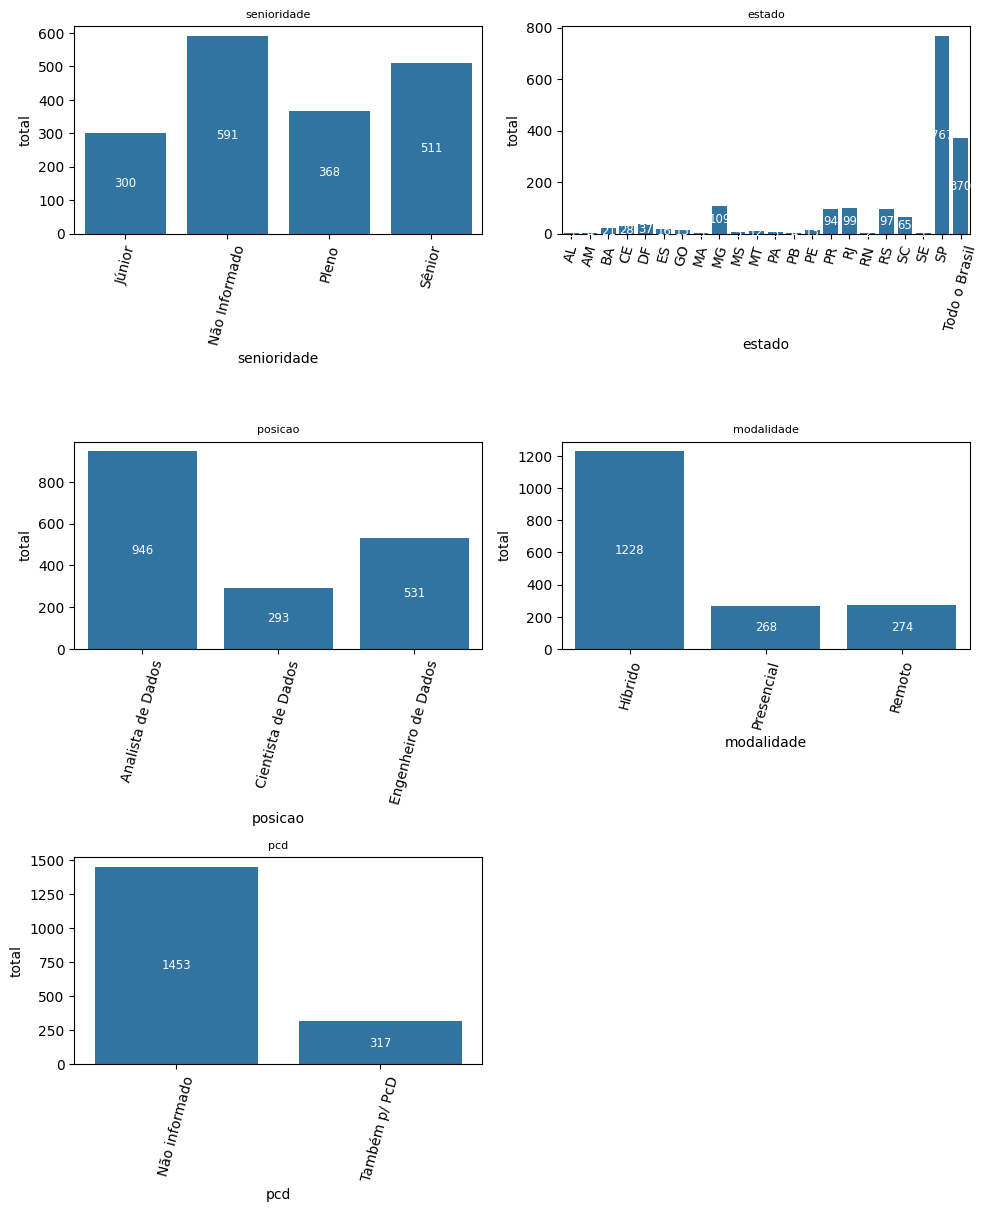

In [69]:
grid = gridspec.GridSpec(4,2)
plt.figure(figsize=(10,15))

cols = ['senioridade', 'estado', 'posicao','modalidade', 'pcd']

for i in range(len(cols)):
    
    q, mod = divmod(i,2)

    f1 = plt.subplot
    col = cols[i]
    barplot(title=f'{col}',
            title_font_size=8,
            group=col,
            agg='link_site', 
            agg_name = 'total',
            agg_func = 'count',
            data = df2,
            subplot = f1,
            grid = grid[q,mod],
            sort=False,
            rotation_label = 75)

plt.tight_layout()

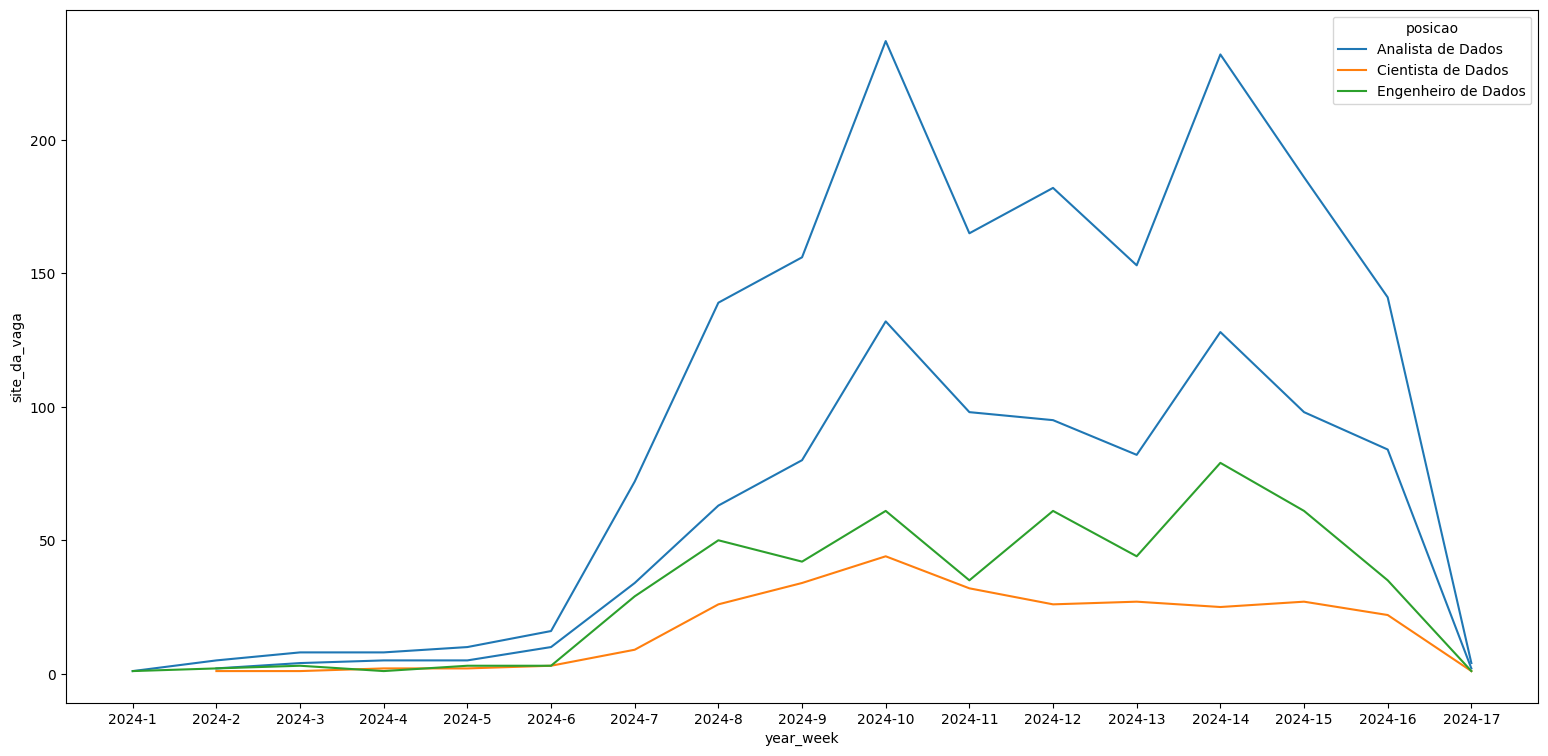

In [88]:
df_aux = df2[df2['data_publicacao'].dt.year == 2024]
aux = df_aux[[ 'site_da_vaga', 'week', 'year_week']].groupby( ['week', 'year_week'] ).count().reset_index()
plt.figure( figsize=(19, 9) )

sns.lineplot( data=aux, x='year_week', y='site_da_vaga' );

aux2 = df_aux[[ 'posicao', 'site_da_vaga', 'week', 'year_week']].groupby( ['posicao', 'week', 'year_week'] )['site_da_vaga'].count().reset_index()
sns.lineplot( data=aux2, x='year_week', y='site_da_vaga', hue='posicao' );

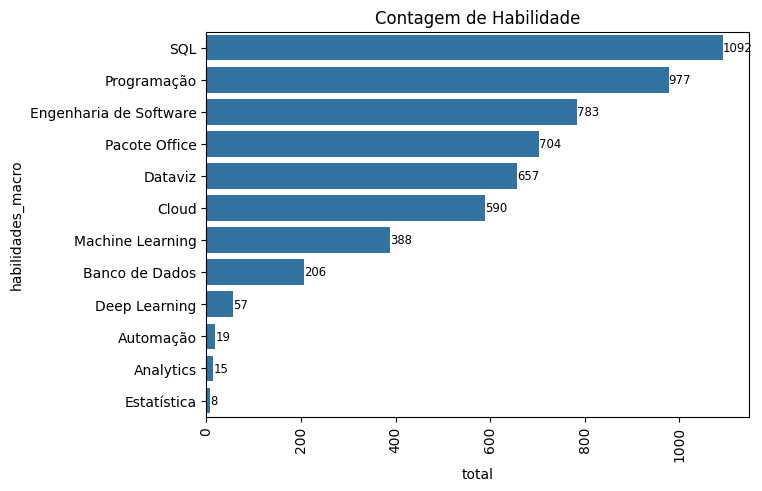

In [31]:
df2_skills = df2.explode('habilidades_macro')

barplot(title='Contagem de Habilidade',
        title_font_size=12,
        group='habilidades_macro',
        agg='link_site', 
        agg_name = 'total',
        agg_func = 'count',
        data = df2_skills,
        figsize=(7,5),
        sort=True,
        label=True,
        rotation_label = 90,
        color_label = 'black',
        position_label='edge',
        size_label='small',
        orient = 'v')

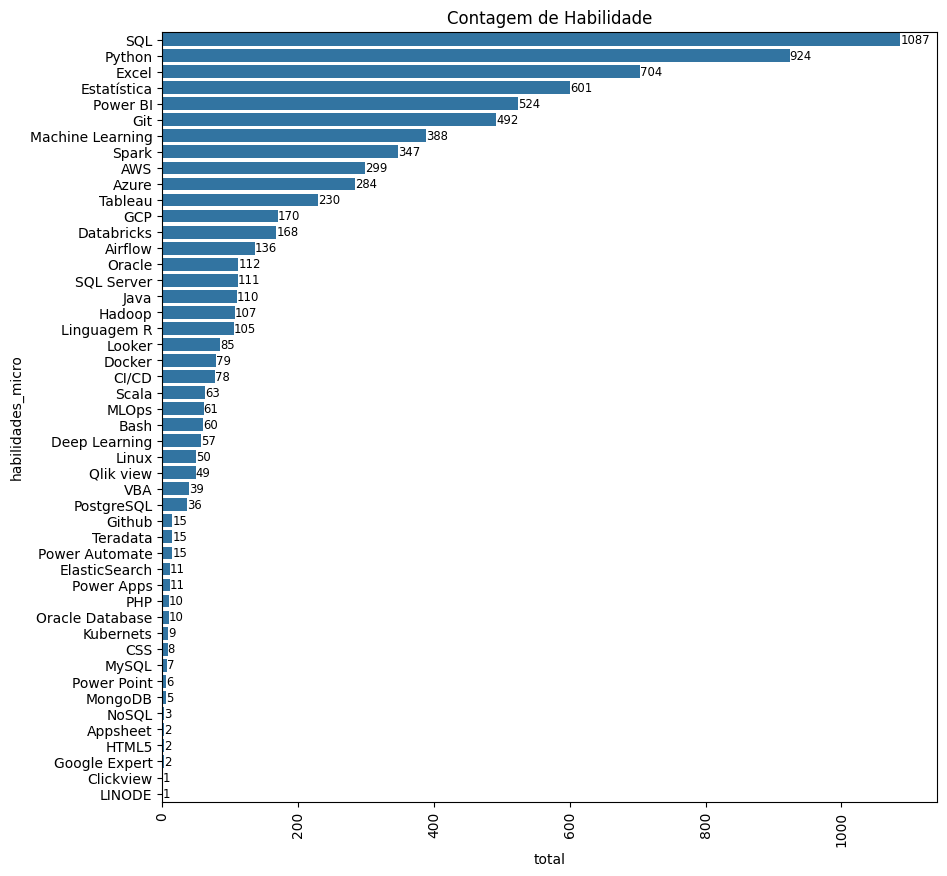

In [79]:
df2_skills = df2.explode('habilidades_micro')

barplot(title='Contagem de Habilidade',
        title_font_size=12,
        group='habilidades_micro',
        agg='link_site', 
        agg_name = 'total',
        agg_func = 'count',
        data = df2_skills,
        figsize=(10,10),
        sort=True,
        label=True,
        rotation_label = 90,
        color_label = 'black',
        position_label='edge',
        size_label='small',
        orient = 'v')

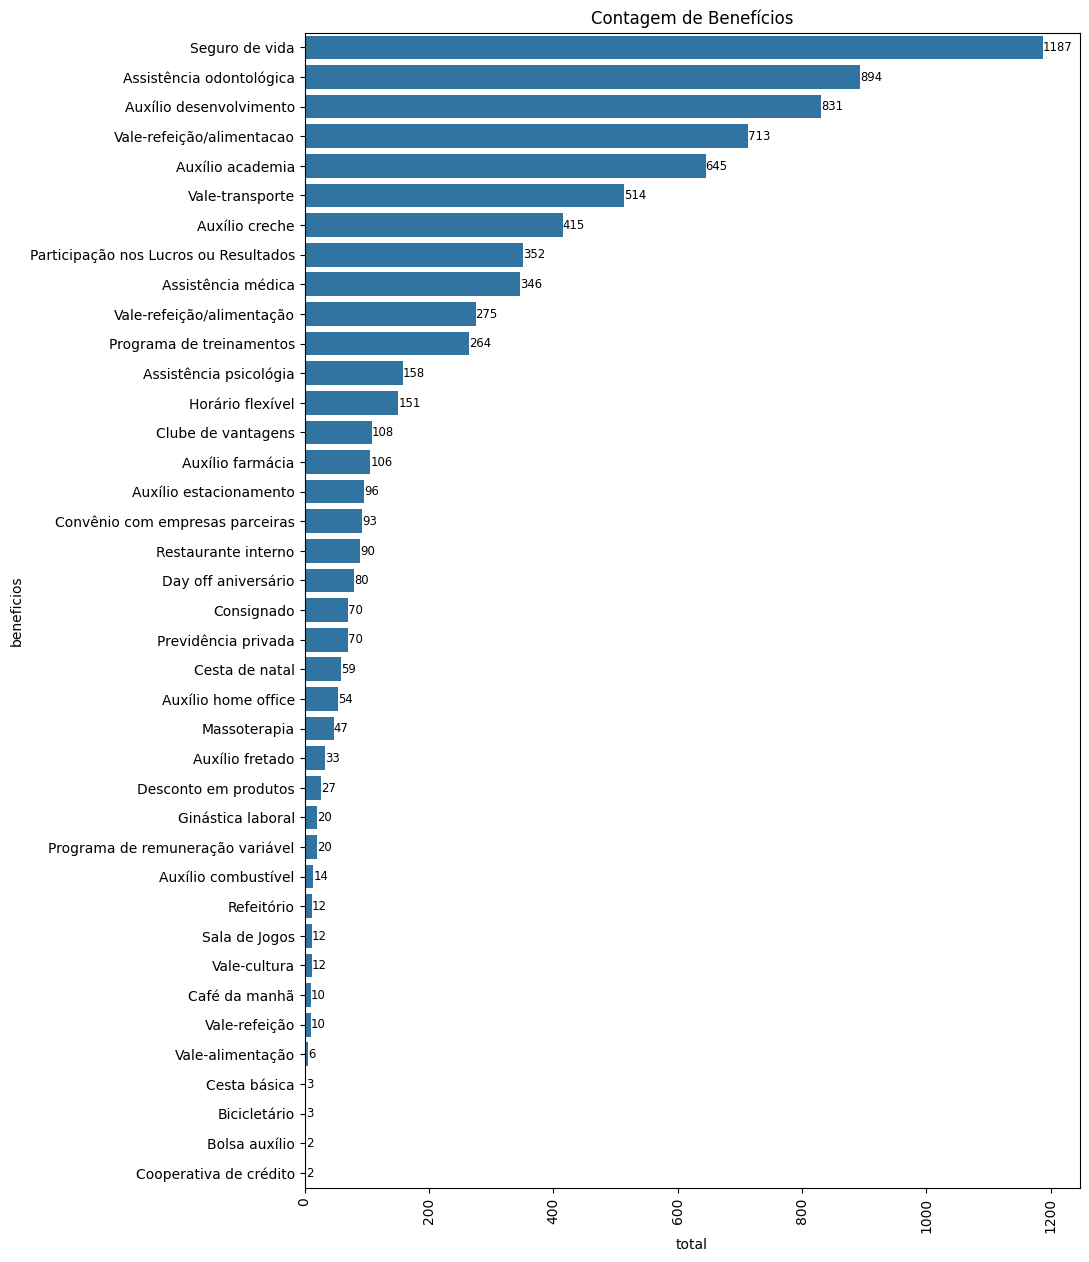

In [80]:
df2_benefits = df2.explode('beneficios')

barplot(title='Contagem de Benefícios',
        title_font_size=12,
        group='beneficios',
        agg='link_site', 
        agg_name = 'total',
        agg_func = 'count',
        data = df2_benefits,
        figsize=(10,15),
        sort=True,
        label=True,
        rotation_label = 90,
        color_label='black',
        position_label='edge',
        size_label='small',
        orient = 'v'
        )

## Análise Bivariada

### Sites

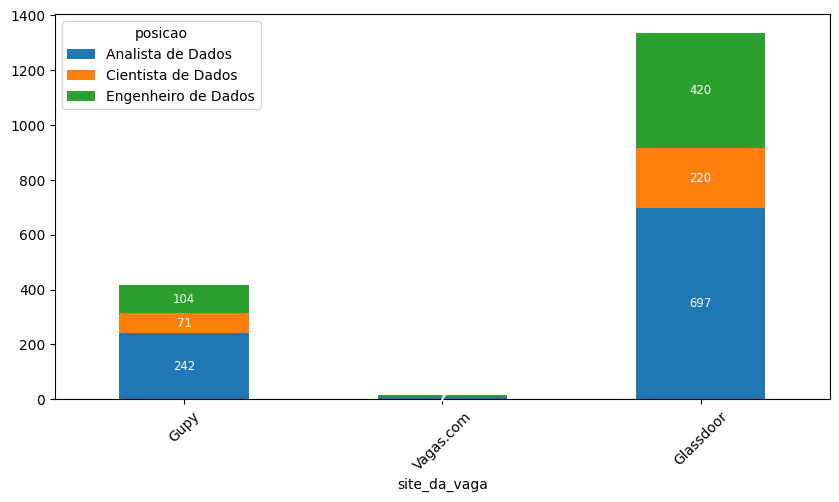

In [81]:
unstacked_plot(
    title = '',
    group='site_da_vaga',
    hue='posicao',
    agg_name='total',
    figsize=(10,5),
    data=df2,
    column_order=df2['site_da_vaga'].unique().tolist(),
    normalize=False,
    fmt = '%.0f'
)

### Senioridade

In [ ]:
df_aux = df2.loc[df2['senioridade'].isin(['Não informado','Júnior','Pleno','Sênior'])]

unstacked_plot(
    title = '',
    group='posicao',
    hue='senioridade',
    agg_name='total',
    # figsize=(10,5),
    data=df_aux,
    normalize=True,
    color_label='black',
    fmt = '%.2f'
)        

### Modalidade

In [ ]:
unstacked_plot(
    title = '',
    group='posicao',
    hue='modalidade',
    agg_name='total',
    # figsize=(10,5),
    data=df2,
    column_order=df2['posicao'].unique().tolist(),
    normalize=True,
    color_label='black',
    fmt = '%.2f'
);

### Tipo de Contrato

In [ ]:
unstacked_plot(
    title = '',
    group='posicao',
    hue='contrato',
    agg_name='total',
    figsize=(10,5),
    data=df2,
    column_order=df2['posicao'].unique().tolist(),
    normalize=True,
    color_label='black',
    fmt = '%.2f'
);

### Remige (CLT, PJ..)

In [ ]:
# unstacked_plot(
#     title = '',
#     group='regime',
#     hue='posicao',
#     agg_name='total',
#     figsize=(10,5),
#     data=df2,
#     column_order=df2['regime'].unique().tolist(),
#     normalize=False,
#     color_label='black',
#     fmt = '%.0f'
# );

### Estado

In [ ]:
unstacked_plot(
    title = '',
    group='estado',
    hue='posicao',
    agg_name='total',
    figsize=(15,5),
    data=df2,
    column_order=df2['estado'].unique().tolist(),
    normalize=False,
    color_label='black',
    fmt = '%.0f'
);

### Habilidades

In [ ]:
df2_skills = df2.explode('habilidades_macro')
df_aux = pd.crosstab(df2_skills['habilidades_macro'], df2_skills['posicao']).reset_index()
df_aux['Analista de Dados'] = df_aux['Analista de Dados'] / df2.loc[df2['posicao'] == 'Analista de Dados'].shape[0]
df_aux['Cientista de Dados'] = df_aux['Cientista de Dados'] / df2.loc[df2['posicao'] == 'Cientista de Dados'].shape[0]
df_aux['Engenheiro de Dados'] = df_aux['Engenheiro de Dados'] / df2.loc[df2['posicao'] == 'Engenheiro de Dados'].shape[0]

df_aux = df_aux.melt(id_vars=['habilidades_macro'], value_vars=['Analista de Dados','Cientista de Dados','Engenheiro de Dados'], value_name='percentual')

plt.figure(figsize=(15,7))
g = sns.barplot(x = 'habilidades_macro', y ='percentual', hue='posicao', data = df_aux)
plt.xticks(rotation = 15)
for i in g.containers:
    g.bar_label(i, label_type='edge', color = 'black', fmt='%.2f', fontsize='small')

In [ ]:
df2_skills = df2.explode('habilidades_micro')

df_aux = pd.crosstab(df2_skills['habilidades_micro'], df2_skills['posicao']).reset_index()
df_aux['Analista de Dados'] = df_aux['Analista de Dados'] / df2.loc[df2['posicao'] == 'Analista de Dados'].shape[0]
df_aux['Cientista de Dados'] = df_aux['Cientista de Dados'] / df2.loc[df2['posicao'] == 'Cientista de Dados'].shape[0]
df_aux['Engenheiro de Dados'] = df_aux['Engenheiro de Dados'] / df2.loc[df2['posicao'] == 'Engenheiro de Dados'].shape[0]

df_aux = df_aux.melt(id_vars=['habilidades_micro'], value_vars=['Analista de Dados','Cientista de Dados','Engenheiro de Dados'], value_name='percentual')

plt.figure(figsize=(7,25))
g = sns.barplot(x = 'percentual', y ='habilidades_micro', hue='posicao', data = df_aux)
plt.xticks(rotation = 15)
for i in g.containers:
    g.bar_label(i, label_type='edge', color = 'black', fmt='%.2f', fontsize='small')

In [ ]:
df2_skills = df2.explode('competencias')

df_aux = pd.crosstab(df2_skills['competencias'], df2_skills['posicao']).reset_index()
df_aux['Analista de Dados'] = df_aux['Analista de Dados'] / df2.loc[df2['posicao'] == 'Analista de Dados'].shape[0]
df_aux['Cientista de Dados'] = df_aux['Cientista de Dados'] / df2.loc[df2['posicao'] == 'Cientista de Dados'].shape[0]
df_aux['Engenheiro de Dados'] = df_aux['Engenheiro de Dados'] / df2.loc[df2['posicao'] == 'Engenheiro de Dados'].shape[0]

df_aux = df_aux.melt(id_vars=['competencias'], value_vars=['Analista de Dados','Cientista de Dados','Engenheiro de Dados'], value_name='percentual')

plt.figure(figsize=(7,10))
g = sns.barplot(x = 'percentual', y ='competencias', hue='posicao', data = df_aux)
plt.xticks(rotation = 15)
for i in g.containers:
    g.bar_label(i, label_type='edge', color = 'black', fmt='%.2f')

In [ ]:
df2_benefits = df2.explode('beneficios')

df_aux = pd.crosstab(df2_benefits['beneficios'], df2_benefits['posicao']).reset_index()
df_aux['Analista de Dados'] = df_aux['Analista de Dados'] / df2.loc[df2['posicao'] == 'Analista de Dados'].shape[0]
df_aux['Cientista de Dados'] = df_aux['Cientista de Dados'] / df2.loc[df2['posicao'] == 'Cientista de Dados'].shape[0]
df_aux['Engenheiro de Dados'] = df_aux['Engenheiro de Dados'] / df2.loc[df2['posicao'] == 'Engenheiro de Dados'].shape[0]

df_aux = df_aux.melt(id_vars=['beneficios'], value_vars=['Analista de Dados','Cientista de Dados','Engenheiro de Dados'], value_name='percentual')

plt.figure(figsize=(7,20))
g = sns.barplot(x = 'percentual', y ='beneficios', hue='posicao', data = df_aux)
plt.xticks(rotation = 15)
for i in g.containers:
    g.bar_label(i, label_type='edge', color = 'black', fmt='%.2f')

## Hipóteses de Negócio

In [ ]:
df_analista = df2.loc[df1['posicao'] == 'Analista de Dados']
df_cientista = df2.loc[df1['posicao'] == 'Cientista de Dados']
df_engenheiro = df2.loc[df1['posicao'] == 'Engenheiro de Dados']

### Analista de Dados

In [ ]:
barplot(
    title = 'Modalidade de Trabalho das posições de Analista de Dados',
    group = 'modalidade',
    agg='link_site',
    agg_name='total de vagas',
    agg_func = 'count',
    data = df_analista
)

In [ ]:
df_aux = df_analista.loc[df_analista['estado'] != 'Todo o Brasil']
barplot(
    title = 'Localidade das vagas de Analista de Dados',
    group = 'estado',
    agg='link_site',
    agg_name='total de vagas',
    agg_func = 'count',
    data = df_aux,
    position_label = 'edge',
    color_label='black'
)

In [ ]:
df_analista_aux = df_analista.explode('competencias')

barplot(
    title = 'Competências mais exigidas nas posições de Analista de Dados',
    group = 'competencias',
    agg='link_site',
    agg_name='total de vagas',
    agg_func = 'count',
    data = df_analista_aux
)

In [ ]:
df_analista_aux = df_analista.explode('habilidades_micro')

barplot(
    title = 'Ferramentas mais exigidas nas posições de Analista de Dados',
    group = 'habilidades_micro',
    agg='link_site',
    agg_name='total de vagas',
    agg_func = 'count',
    data = df_analista_aux,
    orient='v',
    figsize=(10,10)
)

### Cientista de Dados

In [ ]:
barplot(
    title = 'Modalidade de Trabalho das posições de Cientista de Dados',
    group = 'modalidade',
    agg='link_site',
    agg_name='total de vagas',
    agg_func = 'count',
    data = df_cientista
)

In [ ]:
barplot(
    title = 'Localidade das vagas de Cientista de Dados',
    group = 'estado',
    agg='link_site',
    agg_name='total de vagas',
    agg_func = 'count',
    data = df_cientista
)

In [ ]:
df_aux = df_cientista.explode('competencias')

barplot(
    title = 'Competências mais exigidas nas posições de Cientista de Dados',
    group = 'competencias',
    agg='link_site',
    agg_name='total de vagas',
    agg_func = 'count',
    data = df_aux
)

In [ ]:
df_aux = df_cientista.explode('habilidades_micro')

barplot(
    title = 'Ferramentas mais exigidas nas posições de Cientista de Dados',
    group = 'habilidades_micro',
    agg='link_site',
    agg_name='total de vagas',
    agg_func = 'count',
    data = df_aux,
    orient='v',
    figsize=(10,10)
)

### Engenheiro de Dados

In [ ]:
barplot(
    title = 'Modalidade de Trabalho das posições de Engenheiro de Dados',
    group = 'modalidade',
    agg='link_site',
    agg_name='total de vagas',
    agg_func = 'count',
    data = df_engenheiro
)

In [ ]:
barplot(
    title = 'Localidade das vagas de Engenharia de Dados',
    group = 'estado',
    agg='link_site',
    agg_name='total de vagas',
    agg_func = 'count',
    data = df_engenheiro
)

In [ ]:
df_aux = df_engenheiro.explode('competencias')

barplot(
    title = 'Competências mais exigidas nas posições de Engenharia de Dados',
    group = 'competencias',
    agg='link_site',
    agg_name='total de vagas',
    agg_func = 'count',
    data = df_aux
)

In [ ]:
df_aux = df_engenheiro.explode('habilidades_micro')

barplot(
    title = 'Ferramentas mais exigidas nas posições de Engenharia de Dados',
    group = 'habilidades_micro',
    agg='link_site',
    agg_name='total de vagas',
    agg_func = 'count',
    data = df_aux,
    orient='v',
    figsize=(10,10)
)